In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import json
import pickle

import catboost as cb
print("cb.__version__:", cb.__version__)

from sklearn.model_selection import StratifiedGroupKFold

# local modules
import sys
sys.path.append("../src")
from preproc import process_train_data, process_test_data

cb.__version__: 1.2.7


***
### load and preprocess data

In [2]:
# define some paths
path_raw = Path("../data/raw")
path_processed = Path("../data/processed")
path_results = Path("../data/results")

# load data
df_train = pd.read_csv(path_raw / "train.csv")
df_test = pd.read_csv(path_raw / "test.csv")

df_train

,Id,GameRulesetName,agent1,agent2,Properties,Format,Time,Discrete,Realtime,Turns,...,DoLudeme,Trigger,PlayoutsPerSecond,MovesPerSecond,EnglishRules,LudRules,num_wins_agent1,num_draws_agent1,num_losses_agent1,utility_agent1
0,0,00Y,MCTS-ProgressiveHistory-0.1-MAST-false,MCTS-ProgressiveHistory-0.6-Random200-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",4,0,11,-0.466667
1,1,00Y,MCTS-ProgressiveHistory-0.1-MAST-false,MCTS-UCB1GRAVE-0.6-NST-true,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",5,0,10,-0.333333
2,2,00Y,MCTS-ProgressiveHistory-0.1-MAST-true,MCTS-UCB1-0.1-NST-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",7,0,8,-0.066667
3,3,00Y,MCTS-ProgressiveHistory-0.1-MAST-true,MCTS-UCB1-0.6-NST-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",5,0,10,-0.333333
4,4,00Y,MCTS-ProgressiveHistory-0.1-MAST-true,MCTS-UCB1GRAVE-1.41421356237-NST-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",5,0,10,-0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233229,233229,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-NST-false,MCTS-ProgressiveHistory-1.41421356237-Random20...,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",2,0,13,-0.733333
233230,233230,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-Random200-false,MCTS-UCB1-0.6-MAST-false,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",9,1,5,0.266667
233231,233231,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-Random200-false,MCTS-UCB1GRAVE-1.41421356237-NST-false,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",11,3,1,0.666667
233232,233232,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-Random200-false,MCTS-UCB1GRAVE-1.41421356237-NST-true,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",24,2,4,0.666667


In [3]:
# Load the feature selection results
with open('../feat_selection/select_optuna_lgbm.json', 'r') as f:
    feature_selection = json.load(f)

# Extract the selected features
numerical_cols = feature_selection.get('numerical', [])
categorical_cols = feature_selection.get('categorical', [])

print("Numerical features:", len(numerical_cols))
print("Categorical features:", len(categorical_cols))

Numerical features: 296
Categorical features: 5


In [4]:
df_train, numerical_cols, categorical_cols, encoder, scaler = process_train_data(
    df_train,
    scale=False,
    numerical_cols=numerical_cols,
    categorical_cols=categorical_cols
)

# Print the results
print("Numerical Columns:", len(numerical_cols))
print("Categorical Columns:", len(categorical_cols))

number of all nan cols:  0
number of constant cols:  0
Numerical Columns: 370
Categorical Columns: 5


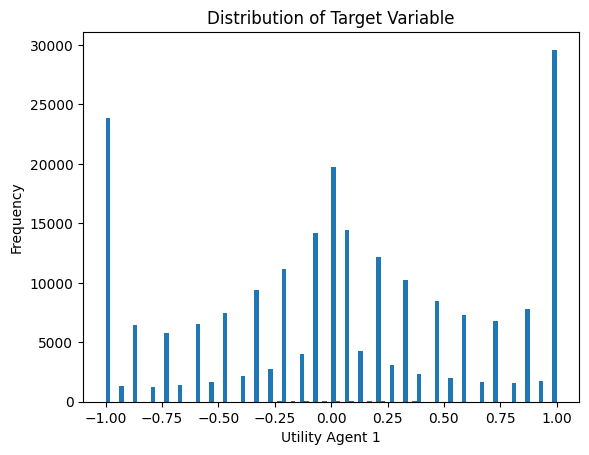

In [5]:
plt.hist(df_train['utility_agent1'], bins=100)
plt.title('Distribution of Target Variable')
plt.xlabel('Utility Agent 1')
plt.ylabel('Frequency')
plt.show()

***
### train model

In [6]:
def get_feature_importance(model, importance_type='PredictionValuesChange'):
    """
    Get feature importance from a trained CatBoost model
    
    Args:
        model: Trained CatBoost model
        importance_type: Type of feature importance to calculate
            Options: 'PredictionValuesChange', 'LossFunctionChange', 
            'ShapValues', 'Interaction', 'TopKitty'
        
    Returns:
        pandas.DataFrame: DataFrame containing feature names and their importance scores
    """
    # Get feature importance scores
    importance_scores = model.get_feature_importance(type=importance_type)
    feature_names = model.feature_names_
    
    # Create dataframe with feature names and importance scores
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importance_scores
    }).sort_values('importance', ascending=False, ignore_index=True)
    
    return importance_df


def plot_feature_importance(importance_df, top_n=100):
    plot_df = importance_df.head(top_n)
    
    plt.figure(figsize=(15, 5))
    plt.bar(x=range(len(plot_df)), height=plot_df['importance'])
    plt.xticks(range(len(plot_df)), plot_df['feature'], rotation=45, ha='right', fontsize=8)
    plt.ylabel('Importance Score')
    plt.title(f'Top {top_n} Most Important Features')
    plt.tight_layout()
    plt.show()

/Users/mavillan/Library/Caches/pypoetry/virtualenvs/mcts-strength-variants-E8z0EJ47-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:994: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Fold 1
0:	learn: 0.5997226	test: 0.6035830	best: 0.6035830 (0)	total: 205ms	remaining: 10m 14s
50:	learn: 0.3952447	test: 0.4621222	best: 0.4621036 (49)	total: 11.9s	remaining: 11m 28s
100:	learn: 0.3593610	test: 0.4453630	best: 0.4453630 (100)	total: 23.8s	remaining: 11m 21s
150:	learn: 0.3385630	test: 0.4391452	best: 0.4391247 (148)	total: 35.8s	remaining: 11m 14s
200:	learn: 0.3246561	test: 0.4352821	best: 0.4352821 (200)	total: 47.7s	remaining: 11m 4s
250:	learn: 0.3139362	test: 0.4318857	best: 0.4318857 (250)	total: 59.8s	remaining: 10m 55s
300:	learn: 0.3057003	test: 0.4299470	best: 0.4299470 (300)	total: 1m 11s	remaining: 10m 45s
350:	learn: 0.2983801	test: 0.4286382	best: 0.4286382 (350)	total: 1m 23s	remaining: 10m 33s
400:	learn: 0.2917551	test: 0.4273465	best: 0.4273465 (400)	total: 1m 35s	remaining: 10m 21s
450:	learn: 0.2861305	test: 0.4264304	best: 0.4264131 (448)	total: 1m 48s	remaining: 10m 14s
500:	learn: 0.2808231	test: 0.4254396	best: 0.4254387 (497)	total: 2m	remain

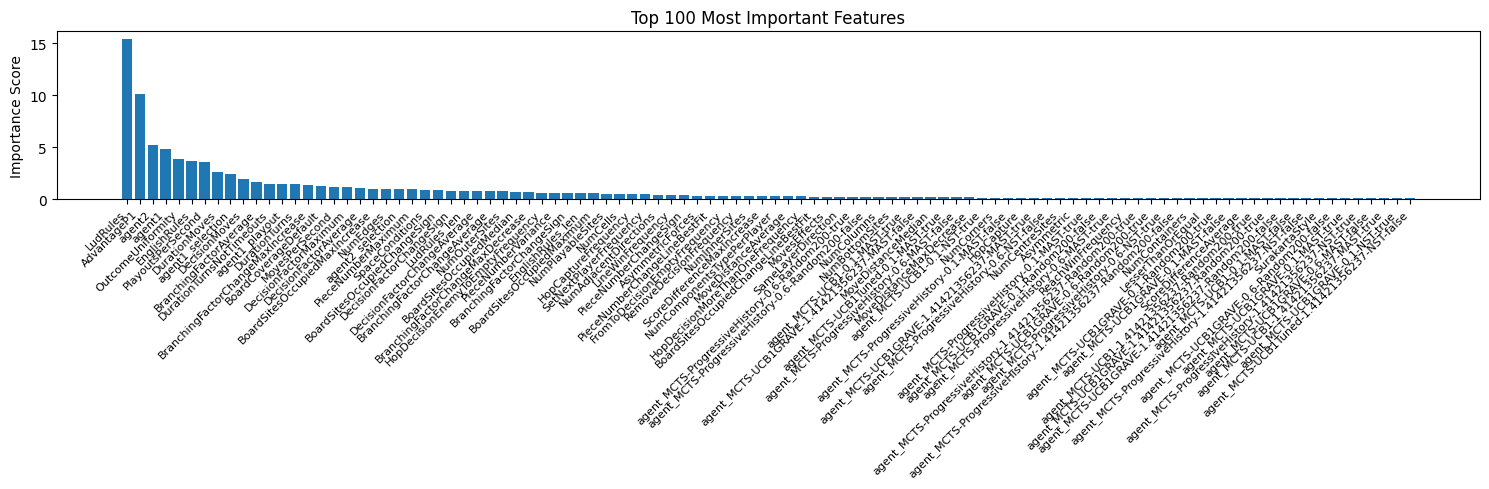

Fold 1 - RMSE: 0.4179230602204132
Fold 2
0:	learn: 0.5970189	test: 0.6202195	best: 0.6202195 (0)	total: 213ms	remaining: 10m 37s
50:	learn: 0.3898230	test: 0.4844758	best: 0.4844758 (50)	total: 11.6s	remaining: 11m 12s
100:	learn: 0.3572303	test: 0.4710467	best: 0.4710467 (100)	total: 23.2s	remaining: 11m 6s
150:	learn: 0.3383709	test: 0.4649169	best: 0.4649169 (150)	total: 34.8s	remaining: 10m 56s
200:	learn: 0.3230459	test: 0.4594273	best: 0.4594273 (200)	total: 46.4s	remaining: 10m 45s
250:	learn: 0.3130843	test: 0.4569600	best: 0.4569600 (250)	total: 58s	remaining: 10m 35s
300:	learn: 0.3043654	test: 0.4547707	best: 0.4547707 (300)	total: 1m 9s	remaining: 10m 26s
350:	learn: 0.2968502	test: 0.4529451	best: 0.4529205 (348)	total: 1m 21s	remaining: 10m 16s
400:	learn: 0.2903333	test: 0.4516564	best: 0.4516564 (400)	total: 1m 33s	remaining: 10m 5s
450:	learn: 0.2847917	test: 0.4505551	best: 0.4505514 (449)	total: 1m 45s	remaining: 9m 54s
500:	learn: 0.2793736	test: 0.4498741	best: 0.4

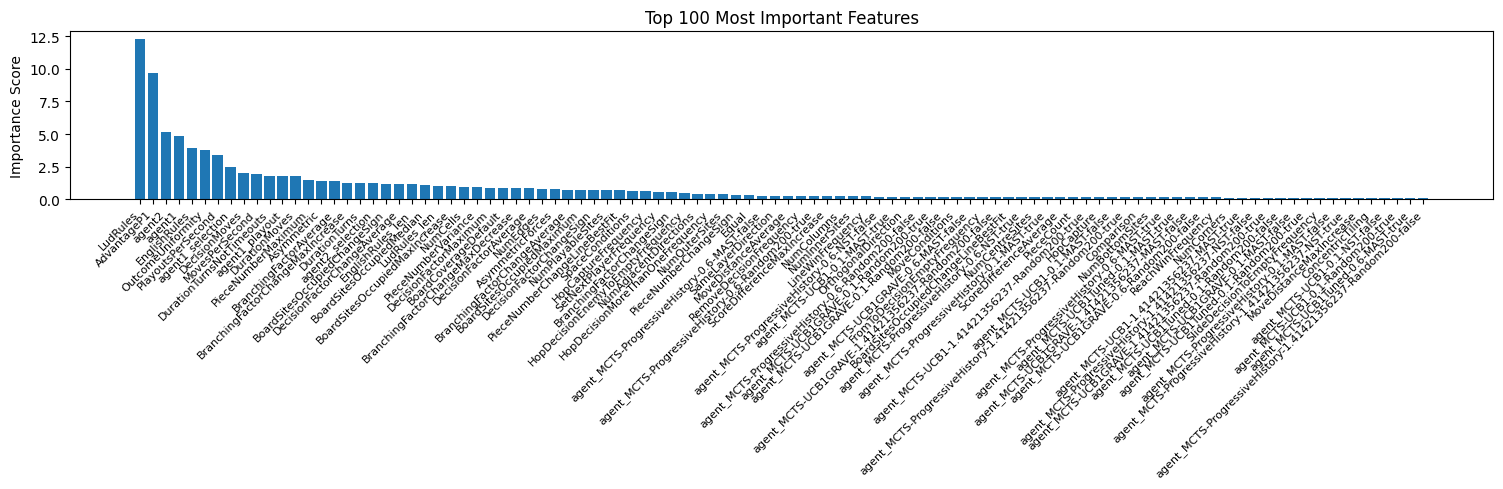

Fold 2 - RMSE: 0.44063688614161267
Fold 3
0:	learn: 0.6052870	test: 0.5832588	best: 0.5832588 (0)	total: 214ms	remaining: 10m 40s
50:	learn: 0.3961071	test: 0.4413474	best: 0.4413474 (50)	total: 12s	remaining: 11m 32s
100:	learn: 0.3609191	test: 0.4253102	best: 0.4252886 (99)	total: 24.7s	remaining: 11m 50s
150:	learn: 0.3398458	test: 0.4173811	best: 0.4173677 (149)	total: 36.6s	remaining: 11m 30s
200:	learn: 0.3266040	test: 0.4127615	best: 0.4127615 (200)	total: 48.7s	remaining: 11m 18s
250:	learn: 0.3154934	test: 0.4091113	best: 0.4091113 (250)	total: 1m	remaining: 11m 3s
300:	learn: 0.3059756	test: 0.4064860	best: 0.4064860 (300)	total: 1m 12s	remaining: 10m 49s
350:	learn: 0.2985041	test: 0.4050500	best: 0.4050500 (350)	total: 1m 24s	remaining: 10m 37s
400:	learn: 0.2918217	test: 0.4032095	best: 0.4032095 (400)	total: 1m 36s	remaining: 10m 25s
450:	learn: 0.2860358	test: 0.4019388	best: 0.4019388 (450)	total: 1m 48s	remaining: 10m 15s
500:	learn: 0.2807484	test: 0.4011700	best: 0.4

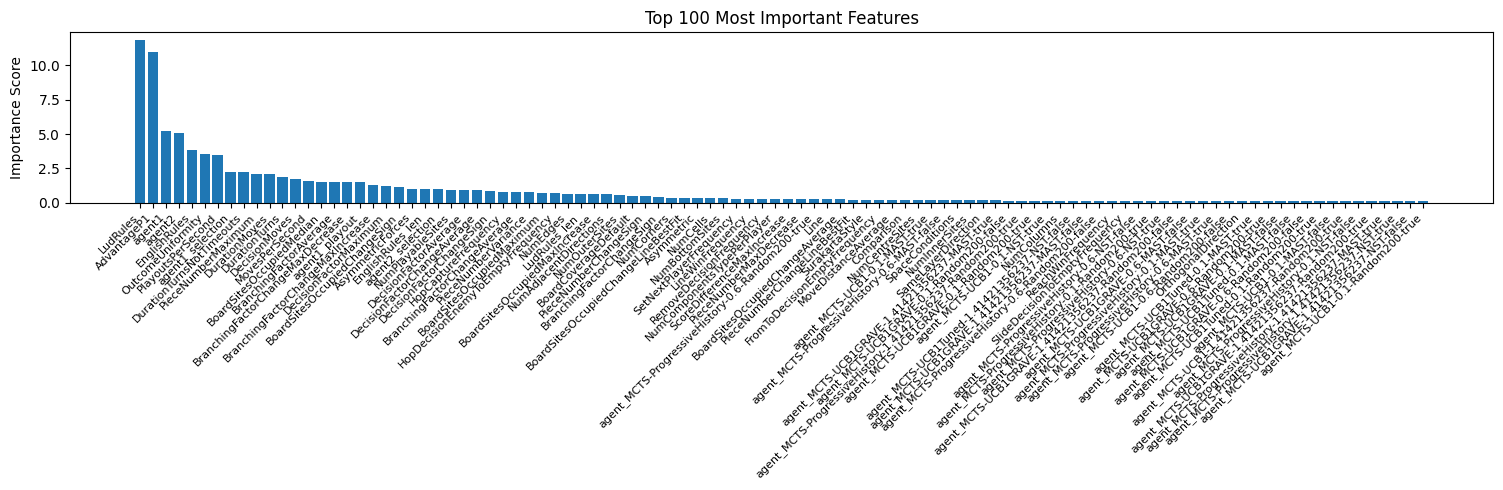

Fold 3 - RMSE: 0.3950276353231221
Fold 4
0:	learn: 0.5980770	test: 0.6149561	best: 0.6149561 (0)	total: 227ms	remaining: 11m 19s
50:	learn: 0.3922328	test: 0.4583690	best: 0.4583690 (50)	total: 11.9s	remaining: 11m 26s
100:	learn: 0.3592148	test: 0.4416887	best: 0.4416887 (100)	total: 23.6s	remaining: 11m 17s
150:	learn: 0.3381056	test: 0.4318770	best: 0.4318770 (150)	total: 35.4s	remaining: 11m 8s
200:	learn: 0.3234928	test: 0.4264670	best: 0.4264670 (200)	total: 47.2s	remaining: 10m 57s
250:	learn: 0.3126454	test: 0.4228539	best: 0.4228539 (250)	total: 59.2s	remaining: 10m 48s
300:	learn: 0.3031046	test: 0.4200257	best: 0.4200257 (300)	total: 1m 11s	remaining: 10m 37s
350:	learn: 0.2954604	test: 0.4182209	best: 0.4182099 (347)	total: 1m 23s	remaining: 10m 26s
400:	learn: 0.2894420	test: 0.4168015	best: 0.4168015 (400)	total: 1m 35s	remaining: 10m 16s
450:	learn: 0.2838977	test: 0.4156622	best: 0.4156622 (450)	total: 1m 46s	remaining: 10m 4s
500:	learn: 0.2788584	test: 0.4145241	best:

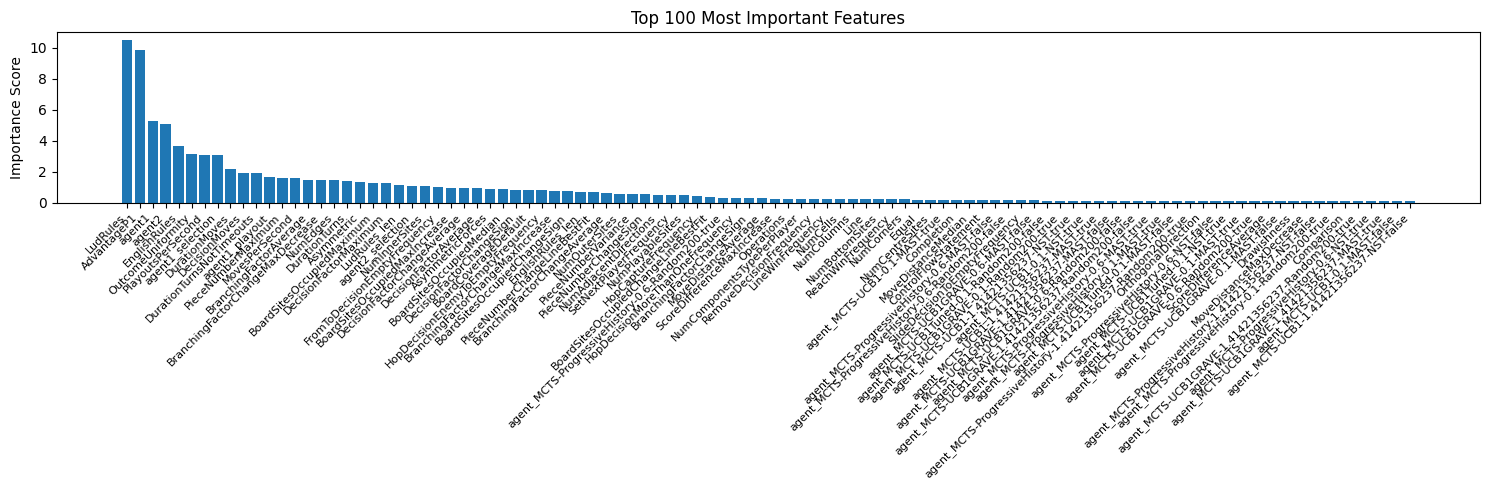

Fold 4 - RMSE: 0.4030441860234947
Fold 5
0:	learn: 0.5990301	test: 0.6104623	best: 0.6104623 (0)	total: 222ms	remaining: 11m 5s
50:	learn: 0.3938329	test: 0.4699137	best: 0.4699137 (50)	total: 11.6s	remaining: 11m 13s
100:	learn: 0.3611219	test: 0.4562202	best: 0.4562202 (100)	total: 23.3s	remaining: 11m 7s
150:	learn: 0.3409453	test: 0.4502630	best: 0.4502630 (150)	total: 34.9s	remaining: 10m 59s
200:	learn: 0.3262531	test: 0.4449857	best: 0.4449857 (200)	total: 46.8s	remaining: 10m 51s
250:	learn: 0.3158066	test: 0.4416983	best: 0.4416983 (250)	total: 58.6s	remaining: 10m 41s
300:	learn: 0.3070337	test: 0.4397550	best: 0.4397252 (296)	total: 1m 10s	remaining: 10m 32s
350:	learn: 0.2993341	test: 0.4381714	best: 0.4381714 (350)	total: 1m 22s	remaining: 10m 22s
400:	learn: 0.2924436	test: 0.4368944	best: 0.4368944 (400)	total: 1m 34s	remaining: 10m 12s
450:	learn: 0.2868502	test: 0.4356722	best: 0.4356722 (450)	total: 1m 46s	remaining: 10m 1s
500:	learn: 0.2815790	test: 0.4350661	best: 

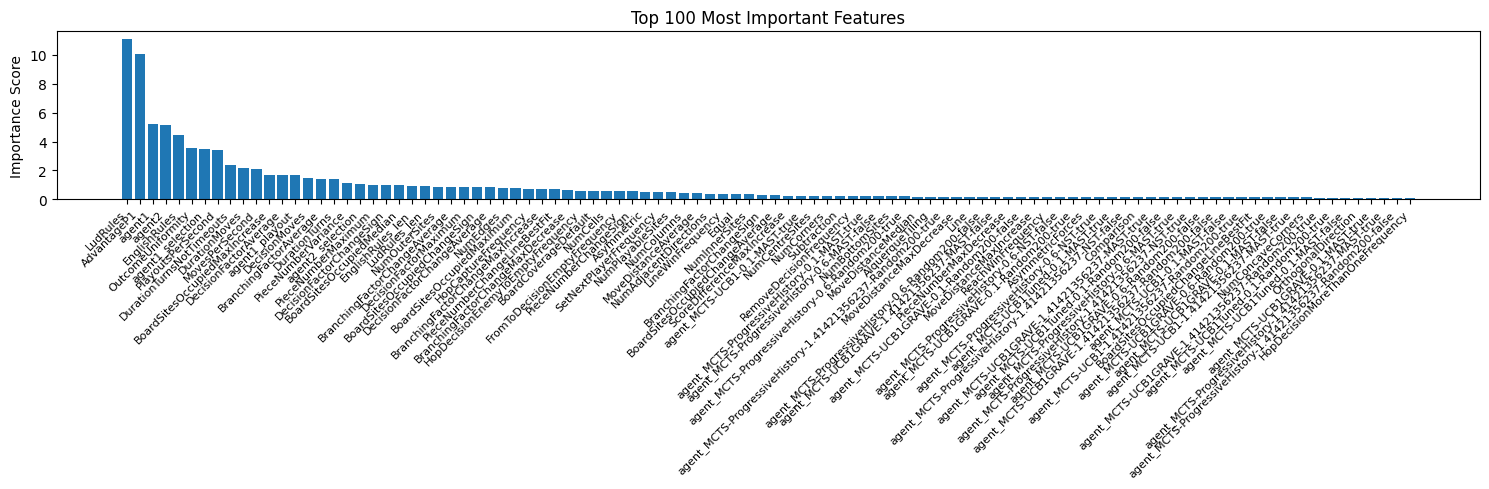

Fold 5 - RMSE: 0.42581592069316676
List of oof scores: [0.4179230602204132, 0.44063688614161267, 0.3950276353231221, 0.4030441860234947, 0.42581592069316676]
Average oof score: 0.4164895376803619


In [19]:
def train_models(
        df_train,
        numerical_cols,
        categorical_cols,
        text_cols,
        target='utility_agent1',
        num_folds=5,
    ):
    # Define the number of folds for cross-validation
    group_col = "GameRulesetName"
    y_col = "utility_agent1_rank"
    gkf = StratifiedGroupKFold(n_splits=num_folds, random_state=2112, shuffle=True)
    split_list = gkf.split(df_train, groups=df_train[group_col], y=df_train[y_col])

    # Define the parameters for CatBoost
    params = {
        'objective': "RMSE",
        'learning_rate': 0.1,
        'depth': 10,
        'iterations': 3000,
        'eval_metric': 'RMSE',
        'verbose': 0,
        'random_seed': 2112,
        'l2_leaf_reg': 1.,
        'random_strength': 0.2,
        'min_data_in_leaf': 50,
        'rsm': 0.8,
        # 'text_processing': {
        #     'tokenizers': [{
        #         'tokenizer_id': 'Space',  # or 'GPT', 'Bert', etc.
        #         'separator_type': 'Space'
        #     }],
        #     'dictionaries': [{
        #         'dictionary_id': 'BiGram',
        #         'max_dictionary_size': '50000',
        #         'occurrence_lower_bound': '3',
        #         'gram_order': '2'
        #     }],
        #     'feature_calcers': [{
        #         'calcer_type': 'BoW',  # or 'NaiveBayes', 'BM25'
        #         'dictionary_id': 'BiGram'
        #     }]
        # }

        # Text processing parameters to mimic TF-IDF
        'tokenizers': [{
            'tokenizer_id': 'Space',
            'separator_type': 'ByDelimiter',
            'delimiter': ' '
        }],
        'dictionaries': [{
            'dictionary_id': 'NgramDict',
            'max_dictionary_size': '500',  # Match max_features=500
            'occurrence_lower_bound': '3',
            'gram_order': '3',  # Maximum n-gram size
            'min_gram_order': '2'  # Minimum n-gram size
        }],
        'feature_calcers': [{
            'calcer_type': 'BoW',  # Most similar to TF-IDF
            'dictionary_id': 'NgramDict'
        }],


        # 'tokenizers': [{
        #     'tokenizer_id': 'Space',
        #     'delimiter': ' ',
        #     'separator_type': 'ByDelimiter'
        # }],
        # 'dictionaries': [{
        #     'dictionary_id': 'Word',
        #     'max_dictionary_size': '50000',
        #     'occurrence_lower_bound': '3'
        # }],
        # 'feature_calcers': [{
        #     'calcer_type': 'BoW',
        #     'dictionary_id': 'Word',
        # }]
    }
    # Obtained with optuna
    # params = {
    #     'objective': 'RMSE',
    #     'verbose': False,
    #     'random_seed': 2112,
    #     'learning_rate': 0.1,
    #     'iterations': 3000,
    #     'bootstrap_type': 'Bayesian',
    #     'sampling_frequency': 'PerTreeLevel',
    #     'depth': 10,
    #     'l2_leaf_reg': 0.9359292512255313,
    #     'random_strength': 0.16693257025108216,
    #     'bagging_temperature': 0.15967219011745193,
    #     'rsm': 0.548125395769786,
    #     'min_data_in_leaf': 102,
    #     'max_ctr_complexity': 10
    # }

    trained_models = []
    oof = pd.DataFrame(index=df_train.index, columns=[f'{target}_true', f'{target}_pred'])
    oof_scores = []

    # Perform cross-validation
    for fold, (train_index, val_index) in enumerate(split_list, 1):
        print(f"Fold {fold}")
        
        # Split the data
        X_train, X_valid = df_train.iloc[train_index], df_train.iloc[val_index]
        y_train, y_valid = X_train[target], X_valid[target]

        # Initialize CatBoost Pool
        train_pool = cb.Pool(
            data=X_train[numerical_cols + categorical_cols + text_cols],
            label=y_train,
            cat_features=categorical_cols,
            text_features=text_cols
        )
        val_pool = cb.Pool(
            data=X_valid[numerical_cols + categorical_cols + text_cols],
            label=y_valid,
            cat_features=categorical_cols,
            text_features=text_cols
        )
        
        # Initialize CatBoost Regressor
        model = cb.CatBoostRegressor(**params)
        
        # Train the model
        model.fit(
            train_pool,
            eval_set=val_pool,
            use_best_model=True,
            verbose=50
        )

        feat_importance = get_feature_importance(model)
        plot_feature_importance(feat_importance)
        
        # Save the trained model to the list
        trained_models.append(model)

        # Predict on validation set
        y_pred = model.predict(val_pool)
        y_pred = np.clip(y_pred, -1, 1)
        
        # Compute RMSE on scaled values
        rmse = np.sqrt(np.mean((y_pred - y_valid) ** 2))
        print(f"Fold {fold} - RMSE: {rmse}")

        # Save out-of-fold predictions
        oof.loc[val_index, f'{target}_true'] = y_valid
        oof.loc[val_index, f'{target}_pred'] = y_pred

        # Save RMSE to the list
        oof_scores.append(rmse)

    # Print the list of oof scores and average oof score
    print("List of oof scores:", oof_scores)
    print("Average oof score:", np.mean(oof_scores))

    return trained_models, oof, oof_scores

# Call the function
trained_models, oof, oof_scores = train_models(
    df_train, numerical_cols, categorical_cols, text_cols=["EnglishRules", "LudRules"]
)

# save oof predictions
#oof.to_csv(path_results / 'oof_catboost.csv', index=False)

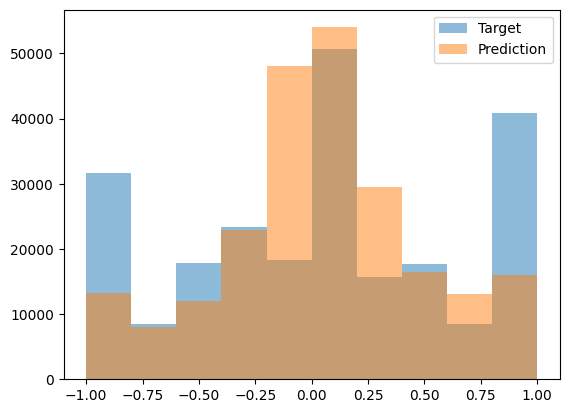

In [10]:
plt.hist(oof['utility_agent1_true'], alpha=0.5, label='Target')
plt.hist(oof['utility_agent1_pred'], alpha=0.5, label='Prediction')
plt.legend()
plt.show()

***
### inference

In [22]:
import os
import polars as pl
sys.path.append("../data/raw/")
import kaggle_evaluation.mcts_inference_server

In [23]:
def predict(test: pl.DataFrame, sample_sub: pl.DataFrame):
    # Convert Polars DataFrame to Pandas DataFrame
    test_pd = test.to_pandas()
    
    # Process the test data
    test_processed = process_test_data(
        test_pd,
        numerical_cols,
        categorical_cols,
        encoder,
        scaler
    )

    # Create CatBoost Pool for test data
    test_pool = cb.Pool(
        data=test_processed[numerical_cols + categorical_cols],
        cat_features=categorical_cols
    )

    # Average predictions from all models
    predictions = np.mean([
        model.predict(test_pool)
        for model in trained_models
    ], axis=0)
    predictions = np.clip(predictions, -1, 1)
        
    # Create the submission DataFrame
    submission = sample_sub.with_columns(pl.Series("utility_agent1", predictions))
    
    return submission

In [24]:
# sanity check
df_test = pl.read_csv('../data/raw/test.csv')
sample_sub = pl.read_csv('../data/raw/sample_submission.csv')
predict(df_test, sample_sub)

agent position feature


Id,utility_agent1
i64,f64
233234,0.121696
233235,-0.129359
233236,-0.089224


In [25]:
inference_server = kaggle_evaluation.mcts_inference_server.MCTSInferenceServer(predict)

if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
    inference_server.serve()
else:
    inference_server.run_local_gateway(
        (
            '../data/raw/test.csv',
            '../data/raw/sample_submission.csv'
        )
    )

agent position feature


In [26]:
# Save all artifacts needed for prediction
catboost_predict = {
    'models': trained_models,
    'numerical_cols': numerical_cols,
    'categorical_cols': categorical_cols,
    'encoder': encoder, 
    'scaler': scaler
}

with open('./catboost_predict.pkl', 'wb') as f:
    pickle.dump(catboost_predict, f)

***
